# Assignment 05: Building Convolution and Pooling Layers from Scratch  (Example Solution)
---

**Due Date:** Tuesday 06/18/2025 (by midnight)

**Please fill these in before submitting, just in case I accidentally mix up file names while grading**:

Name: Jane Hacker

CWID-5: (Last 5 digits of cwid)

# Introduction 

Welcome to our first assignment for the classes Computer Vision and Convolutional Networks section.  In this assignment you are going to implement functions to perform the convolutional and pooling layer operations in numpy.  Each function you will implement will have detailed instructions that will walk you through the steps needed:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (TODO)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (TODO)
    
This notebook will ask you to implement these functions from scratch in `numpy`. 


**Instructions:**

- The forward pass convolution and pooling functions could be vectorized.  However for this assignment, the purpose is to learn conceptually how the
  convolution and pooling operations work.  So you should use for loop iterations as described for these function.  We leave it as an exercise for the
  student to think how you might go about fully vectorizing the convolution and pooling function.
- As with the previous assignment, you will need to create the function declarations asked for
  in `src/assg_tasks.py`.  Make sure you use
  [Python Docstrings](https://www.geeksforgeeks.org/python-docstrings/) and are generally
  following [Pep8 Python Style Guide](https://peps.python.org/pep-0008/) for your code.

**You will learn:**

- How to figure out the resulting size of an output height x width shape for a convolution
  or maxpooling operation given the stride size, padding and kernel sizes being used.
- How convolutions are computed at the basic level for a convolution layer.
- How max pooling and average pooling works and is implemented

# Packages

The following imports should be all of the backages that you will need for this assignment.
We are using the Keras API in this assignment and in future assignments, so the `tensorflow` and `keras` modules
you need are now available in the notebook.

In [1]:
# assignment wide imports go here, usually all of your imports for noteboosk should
# be put up at the top here, if they were not given to you at the start of the assignment
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from mlxtend.plotting import plot_decision_regions

2025-06-12 00:43:38.183989: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 00:43:38.188422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 00:43:38.197777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749689018.212043    2969 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749689018.216167    2969 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749689018.229533    2969 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# The following ipython magic will reload changed file/modules.
# So when editing function in source code modules, you should
# be able to just rerun the cell, not restart the whole kernel.
%load_ext autoreload
%autoreload 2

The imports of the function you will write have been commented out here this time.  You will need to uncomment
the imports once you declare and write your functions here, and also in the `src/test_assg_tasks.py` file to
run the unit tests on your work.

In [3]:
# Import functions/moduls from this project.  We manually set the
# PYTHONPATH to append the location to search for this assignments
# functions to just ensure the imports are found
import sys
sys.path.append("../src")

# assignment function imports for doctests and github autograding
# these are required for assignment autograding
from assg_utils import run_unittests, run_doctests
#from assg_tasks import calc_new_height_width
#from assg_tasks import pool_forward
#from assg_tasks import zero_pad
#from assg_tasks import conv_single_step
#from assg_tasks import conv_forward

In [4]:
# set notebook wide defaults for small image plots
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Task 1: Pooling Layer Implementation

We will start with the pooling layer as its implementation is similar to but slightly
easier than the convolution layer.  But first, a utility function that will be used for both
types of layers to determine what the output height and width will be as a result
of the layer performing its operation.

## Task 1.1: Compute Output height x width of Sliding conv/pool Window

A useful function will be to compute what the new output height and width
of a convolution or pooling operation will be given the input height, width, the kernel_size 
of the window, and the stride and padding values.

The following is a simple animation of the sliding window for a convolution:

<img src="../figures/single_step_convolution_animation.gif" style="width:500px;height:300px;">

**Sliding Window**: with a `kernel_size` of 3x3 and a `stride` of 1 (stride = amount you move the window each time you slide)

For example, in the animation above there is no padding so `pad = 0` and and
the stride step is 1 so `stride = 1`.  In the animation, the input activation has
a `height x width` of `5x5`.  That means that the new `height x width` ends up being
`3x3` for the output after sliding the kernel window over the input.

But if we add `pad = 1` then the new `height x width` would be preserved and would be
`5x5`.  If we did a `pad = 2` then the new ouput would increase to `6x6`.

But also we have to take into account stride.  So for example with no padding
and a `stride = 2` we would only be able to slide 2 times horizontally and vertically,
resulting in a `2x2` output.

You could probably work out from first principles a formula for what the resulting new width and new height
would be given an input `width x height`, the window `kernel_size` and stride and padding.  But to save a little time, the
following expressions will calculate these.  We use the following variables in these formula:

- `height` and `width` are the height and width of the input activation that we are convolving over.
- `kernel_size` is the size of the convolution kernel window.  We will always use a square kernel,
  so for example when `kernel_size` is 3, we are sliding a 3x3 window over the input for
  the convolution.
- `strice` and `pad` are the stride size (minimum 1) and the amount of padding added (can be 0).

So in that case the `new_height` and `new_width` would be:

\begin{equation}
new\_height = \left\lfloor \frac{height - kernel\_size + 2 \times pad}{stride} \right\rfloor + 1
\end{equation}

\begin{equation}
new\_width = \left\lfloor \frac{width - kernel\_size + 2 \times pad}{stride} \right\rfloor + 1
\end{equation}

Where $\left\lfloor x \right\rfloor$ represents the mathematical `floor()` function, though
this is only to ensure that the result is an integer.  You could cast to an int, or in
python3 you could use the `//` which forces integer division in an expression.

**Task**: Write a utility function named `cacl_new_height_width()`.  This function should take
the following parameters in this order:

- `height` and `width` of the input activation
- the `kernel_size` of the sliding window
- `stride` and `pad` settings

It should calculate and return the 
resulting `new_height` and `new_width` as a tuple, which are required to be `int` types.

In [5]:
### TESTED function calc_new_height_width
# uncomment when ready to run the unit tests for function, and uncomment below to test expected results
#run_unittests(['test_calc_new_height_width'])

# a simple case, the above 5x5 input with kernel_size 3, stride 1 and 0 padding
height = width = 5
kernel_size = 3
stride = 1
pad = 0
#new_height, new_width = calc_new_height_width(height, width, kernel_size, stride, pad)
#print(new_height, new_width)

# a bit more complex, 12x21 input, kernel_size 4, stride 2 and pad 2
height = 12
width = 21
kernel_size = 4
stride = 2
pad = 2
#new_height, new_width = calc_new_height_width(height, width, kernel_size, stride, pad)
#print(new_height, new_width)


**Expected Result**:  You should get the following output for the two cases shown

```
3 3
7 11
```

## Task 1.2: Forward Pooling

The pooling layer downsamples.  In other words it reduces the height and width of the input.
It helps reduce computation, as well as helps make feature detectors more invariant to its
position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an (`kernel_size` x `kernel_size`) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an (`kernel_size` x `kernel_size`) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="../figures/max_pool.png" style="width:500px;height:300px;">
<td>

<td>
<img src="../figures/average_pool.png" style="width:500px;height:300px;">
<td>
</table>

**Task**: Implement a function named `pool_forward()`.

This function will take in the following input parameters

- `A`: The input activation into this pooling layer.  This is a numpy array
       of shape `(m, height, width, channels)` which has `m` input samples, each a
       `(height, width, channels)` shaped 3D tensor.
- `kernel_size`: The kernel size to use for the pooling function.  For example
       a kernel size of 2 will use a 2x2 window and will downsample 2x,
       a kernel size of 3 by 3x
- `mode`: A string, either 'max' or 'avg', should default to 'max' if not
       specified.

This function returns the downsampled/pooled result of processing the
input activations `A`.  

**Algorithm Description**

Implementing pooling can be done in the following way:

1. Query the input activations `A` to find out the number of
   samples `m`, `height`, `width` and `channels` of the incoming activations.
2. Calculate the `new_height` and `new_width` that will result.  You are required to
   reuse your previous `calc_new_height_width()`.  The idea is that there is
   no padding in pooling, so `pad = 0`.  And you are striding by the
   `kernel_size` each time to have nonoverlapping windows.
3. Initialize an empty or 0 array to hold the returned pooled results, for example
   calling it `Z`.  You know the resulting shape after pooling
   will be `(m, new_height, new_width, channels)`
4. You will need a 4 deep nested for loop over samples, new_height, new_width,
   channels.
```python
for s in range(m):
    for h in range(new_height):
        # you need to calculate the start and end for dimension 1 height slice
        for w in range(new_width):
            # you need to calculate the start and end for dimension 2 height slice
            for c in range(channels):
                # you need the window from A[s, hstart:hend, vstart:vend, c] to pool
                # get the max or average of the window slice from A and save in Z[s, h, w, c]
                
```
The only tricky part in your loop is, given the h and w index for the pooled output, you have to
calculate the start and end index for your input activations.  Just as an example, if the
`kernel_size` for the window is 3, then when `h=0` and `w=0` the first time in the loop you
need the `A[s, 0:3, 0:3, c]` window slice to average or find maximum of.  When `w` increments to 1,
you then need the window slice `A[s, 0:3, 3:6, c]`, etc.  Each increment of h and w slides the
start and end index of the slice you need by the kernel size of the window being used for the pooling.

5. Return the filled in `Z` array that is the result of pooling using your sliding window.

In [6]:
### TESTED function pool_forward
# uncomment when ready to run the unit tests for function, and uncomment below to test expected results
#run_unittests(['test_pool_forward'])
np.random.seed(1)
A = np.random.randint(-5, 5, size=(3, 4, 4, 4))

print('Max pooling:')
kernel_size = 2
#Z = pool_forward(A, kernel_size, mode='max')
#print('Z.shape: ', Z.shape)
# sample 2 channel 2 input
print('A sample 2 channel 2')
print(A[2, :, :, 2])
#print('Z sample 2 channel 2')
#print(Z[2, :, :, 2])

print('\nAverage pooling:')
kernel_size = 2
#Z = pool_forward(A, kernel_size, mode='avg')
#print('Z.shape: ', Z.shape)
# sample 2 channel 2 input
print('A sample 2 channel 2')
print(A[2, :, :, 2])
#print('Z sample 2 channel 2')
#print(Z[2, :, :, 2])

Max pooling:
A sample 2 channel 2
[[ 1  1 -4 -1]
 [ 4  4 -1  3]
 [ 0  3 -4 -2]
 [-2 -1 -5 -2]]

Average pooling:
A sample 2 channel 2
[[ 1  1 -4 -1]
 [ 4  4 -1  3]
 [ 0  3 -4 -2]
 [-2 -1 -5 -2]]


**Expected Output**: For the given seed you should get the
following output for your max and average pooling.

```
Max pooling:
Z.shape:  (3, 2, 2, 4)
A sample 2 channel 2
[[ 1  1 -4 -1]
 [ 4  4 -1  3]
 [ 0  3 -4 -2]
 [-2 -1 -5 -2]]
Z sample 2 channel 2
[[ 4.  3.]
 [ 3. -2.]]

Average pooling:
Z.shape:  (3, 2, 2, 4)
A sample 2 channel 2
[[ 1  1 -4 -1]
 [ 4  4 -1  3]
 [ 0  3 -4 -2]
 [-2 -1 -5 -2]]
Z sample 2 channel 2
[[ 2.5  -0.75]
 [ 0.   -3.25]]
```

# Task 2: Convolutional Layer Implementation

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

<img src="../figures/conv_nn.png" style="width:350px;height:200px;">

In this part, you will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself. 

## Task 2.1: Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="../figures/zero_padding.png" style="width:600px;height:400px;">

 **Zero-Padding** Image (3 channels, RGB) with a padding of 2.

The main benefits of padding are the following:

- It allows you to use a convolution layer without necessarily shrinking
  the height and width of the volumes. This is important for building deeper
  networks, since otherwise the height/width would shrink as you go to deeper
  layers. An important special case is the "same" convolution, in which
  the height/width is exactly preserved after one layer. 
- It helps us keep more of the information at the border of an image.
  Without padding, very few values at the next layer would be affected
  by pixels as the edges of an image.

**Task**: Implement a function named `zero_pad()` which pads all the
images of a batch of examples `X` with zeros.  

The function takes the following input parameters:

- `X` as input, a numpy array of shape `(m, height, width, channels)`
  representing `m` samples of pictures with shape `(height, width, channels)`
- Also it takes a second paramter `pad` which should default to 1, and is an intiger indicating
the number of padding pixels around each image border.

The function should be vectorized.  You probably want to use the
numpy [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)
function, which will do most of the work for you.

X.shape:      (4, 3, 3, 3)
X[0, :, :, 0]
[[ 37  72 203]
 [192 204 252]
 [178 101 139]]


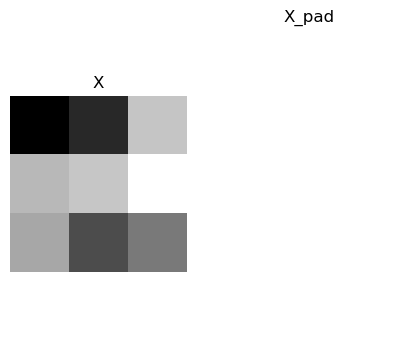

In [7]:
### TESTED function zero_pad
# uncomment when ready to run the unit tests for function, and uncomment below to test expected results
#run_unittests(['test_zero_pad'])

np.random.seed(1)
X = np.random.randint(0, 256, size=(4, 3, 3, 3))
#X_pad = zero_pad(X, 2)

# expected shapes and padding
print('X.shape:     ', X.shape)
#print('X_pad.shape: ', X_pad.shape)
print('X[0, :, :, 0]')
print(X[0, :, :, 0])
#print('X_pad[0, :, :, 0]')
#print(X_pad[0, :, :, 0])

# visualize expected padding
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X[0, :, :, 0]);
ax[0].set_title('X')
ax[0].axis(False)
#ax[1].imshow(X_pad[0, :, :, 0])
ax[1].set_title('X_pad')
ax[1].axis(False);

**Expected Output**: You should get:

```
X.shape:      (4, 3, 3, 3)
X_pad.shape:  (4, 7, 7, 3)

X[0, :, :, 0]
[[ 37  72 203]
 [192 204 252]
 [178 101 139]]
 
X_pad[0, :, :, 0]
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0  37  72 203   0   0]
 [  0   0 192 204 252   0   0]
 [  0   0 178 101 139   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
```

And the small visualization should show black edges for your zero padding of
pad width 2.

## Task 2.2: Single Step of Convolution Operation

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="../figures/single_step_convolution_animation.gif" style="width:500px;height:300px;">


**Convolution operation**: with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide)

**Note** The animation shows as if there is only a single channel, but in reality the
input slice and window weights might have multiple channels of depth coming into this function.

In a computer vision application, each value in the matrix on the left corresponds
to a single pixel value, and we convolve a 3x3 filter with the image by 
**multiplying** its values **element-wise** with the original matrix,
then **summing them up** and **adding a bias**. In this first step of
the task, you will implement a single step of convolution,
corresponding to applying a filter to just one of the positions to
get a single real-valued output. 

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation.

**Task**: Declare and implement a function named `conv_single_step()`.  This
function will take 3 input parameters:

- `slice`: A slice of input data of shape (kernel_size, kernel_size, channels)
- `W`: Weight parameters of the filter kernel, also of shape (kernel_size, kernel_size, channels)
- `b`: Bias parameters of kernel filter, shape (1, 1, 1)

Your function will return a single scalar value, which is the result of convolving
the sliding window (W, b) on the slice of the input data.  This function should
also be vectorized. 

**Hint**: you need to do an element wise multiplication, sum
the result, and add the bias. 

**Hint**: we pass in the bias as a 3-D tensor with 
1 row, 1 column, 1 channel for a reason, but if you add a scalar to an array you
will get an array, but your function must return a scalar value.  You should use
the `.item()` member function in most recent NumPy version to convert an array of
1 value to a scalar value.

In [8]:
### TESTED function conv_single_step
# uncomment when ready to run the unit tests for function, and uncomment below to test expected results
#run_unittests(['test_conv_single_step'])

np.random.seed(1)
slice = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

print(slice.shape)
print(W.shape)
print(b.shape)

#c = conv_single_step(slice, W, b)
#print('c = ', c)

(4, 4, 3)
(4, 4, 3)
(1, 1, 1)


**Expected Output**: The expected result with this random seed should be a single scalar
floating point value:

```
(4, 4, 3)
(4, 4, 3)
(1, 1, 1)
c =  -6.999089450680221
```

## Task 2.3: Convolution Forward Pass

In the forward pass, you will take many filters and convolve them on
the input.  Each 'convolution' gives you a 2D matrix output.  You
will then stack these outputs to get a 3D volume:

<center>
<video width="620" height="440" src="../figures/convolution_animation.mp4" type="video/mp4" controls>
</video>
</center>

You are required to reuse your previous functions `calc_new_height_width()`
and `zero_pad()` in this next task.  The `slice` will be taken by sliding over
the input activation `A` into this function.  `W` and `b` are really the filter weights 
biases of the kernels for this convolution layer.  If you recall, in keras
the parameter `filters=32` specifies the number of output
filters/channels that are produced by a convolution layere.  So the final
dimension of the `W` and `b` parameters are the number of output
filters that the convolution produces.

**Task**: Implement a function named `conv_forward()` to convolve the
filters `W` / `b` on the input activation `A`.  The input parameters to this
function are as follows:

- `A`: The input activation into this convolution layer.  This is a numpy array of shape
       `(m, height, width, channels_prev)`.  There will be `m` samples that come
       in, all of the same `height x width` and with some number of channels.
- `W`: The kernel Weights, a numpy array of shape
       `(kernel_size, kernel_size, channels_prev, channels)`.  The first 3
       dimensions need to be convolved with the input activations.  Notice the
       4th dimension.  If the number of output filters of this convolution is 32,
       then the last dimension would be 32 here, and you can think of `W` then
       as having 32 individual weight kernels of shape
       `(kernel_size, kernel_size, channels_prev)`
- `b`: The kernel biases, which will be shaped `(1, 1, 1, channels)`.  Basically
       there is one bias for every output channel this convolution produces.
- `stride`: The stride size, an integer, should default to 1.
- `pad`: The padding size to use, defaults to 0 to indicate use no padding.
  
This function returns the calculated convolution output activation `Z` that results
from convolving all `W`/`b` kernal parameters over the input activations `A`.  

- `Z`: convolution output, will be of shape `(m, new_height, new_width, channels)`
  You can of course determine the number of samples `m` from the input Activation first
  dimension, and the number of output channels `channels` are the 4th dimension
  size of both `W` and `b`.  The `new_height` and `new_width` of course depend on
  the `stride` and `pad` values.

**Algorithm Description**

For this task you do not need to implement a vectorized solution.  It is possible to vectorize, but
create a solution here using for loop iterations.

The basic algoirthm to do this is as follows:

1. Extract the number of samples `m` and the original input `height` and `width` from the
   passed in input activations `A` shape.
2. Also you need the `kernel_size` and the number of `new_channels` which you can get from the passed
   in `W` kernel weights shape.
3. Given that information and the `stride` and `pad` which are given as parameters, you have enough
   information to reuse your `calc_new_height_width` to calculate what the output height and width
   will be for this convolution on the input `height` `width` and given the `kernel_size`,
   `stride` and `pad` being used.
4. Create an empty or zero filled array, which you could call `Z` for example, that will be the
   returned results from the convolution.  The returned convolutions should have shape
   `(m, new_height, new_width, channels)`
5. Reuse your `zero_pad` function to pad the input activations `A` as needed before beginning
   your calculation of the convolutions.

Then to implement this in an iterative fashion, you need a 4 deep nested loop doing:

```python
for s in range(m):
    for h in range(new_height):
        # you need to calculate the start and end for dimension 1 height slice
        for w in range(new_width):
            # you need to calculate the start and end for dimension 2 height slice
            for c in range(channels):
                # you need the window from A[s, hstart:hend, vstart:vend, :] to pool
                # you need to also slice the weights and biases to get only channel c kernel
                # calculate Z[s, h, w, c] here using your conv_single_step()

```

6. Return the resulting Z output activations as your result.

This is similar to the previous pooling implementation, with minor changes.  But in the main
loops of the function, you need to do the same calculations to get the sliding window
slice indexes.  Note: one differenc, the slice of A needs all of the previous channels.  You are
only slicing `W` and `b` by the current channel `c` being iterated.

In [9]:
### TESTED function conv_forward
# uncomment when ready to run the unit tests for function, and uncomment below to test expected results
#run_unittests(['test_conv_forward'])

np.random.seed(1)
# input activations have 10 samples, 5x7 shape, with 4 channels coming in
A = np.random.randn(10,5,7,4)
# the settings of the kernel W/b parameters.  This convolution creates
# 8 channel/filter outputs. The kernel size is 3, and because
# we use stride=2 pad=1 the new heightxwidth are 4x8
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
stride = 2
pad = 1

#Z = conv_forward(A, W, b, stride, pad)
#print('Z.shape: ', Z.shape)
#print('Z.mean:  ', np.mean(Z))
#print('Z channel means: ', Z.mean(axis=0).mean(axis=0).mean(axis=0)) # this is mean of each 8 channels
#print('Z channel maxs: ', Z.max(axis=0).max(axis=0).max(axis=0)) # this is max of each 8 channels
#print('Z sample 3, channel 2:')
#print(Z[3,:,:,2])

**Expected Output** You should get the following results for this example
when using the given random seed:

```
Z.shape:  (10, 3, 4, 8)
Z.mean:   0.6923608807576933
Z channel means:  [ 1.5086006  -0.1743384   2.68375965 -0.35835072  2.76845058 -1.12789915
 -0.41870826  0.65737275]
Z channel maxs:  [11.12355835 23.48197533 19.73741108 10.69033276 19.89262537  9.97188609
 13.00689405 12.78954327]
Z sample 3, channel 2:
[[ 4.54315363  6.3188805   9.48395578  1.95844304]
 [ 8.07643821  9.59542022 19.73741108 -1.3748106 ]
 [ 3.36457258  6.61941931  9.9232075   8.78183548]]
```

Congratulations on completing this assignment. You now understand the most important mechanisms for convolutional neural networks.
Hopefully you rememberd to make commits after each of the task functions and have pushed them to your GitHub repository for grading. 

<font color='blue'>
    
**What to remember from this assignment:**

- The sliding window / kernel for pooling and convolutions conceptually work in a similar way.
- The resulting output shape for a pooling or convolution operation depends on the window kernel_size, and the stride
  and padding settings.
- While the pooling and convolution operations can be made much more efficient by vectorizing them, iterating over each sample,
  height, width and channel and computing the window slice for that combination gives the essential idea of what happens in
  a convolution or pooling operation.
- The convolution operation is really just a elementwise multiplication of two volumes of equal shape with a bias added in.  The result is a
  single scalar value.  This scalar represents the output for a particular sample, window slice, and channel number of the convolution.
- We usually use max pooling, but can use average pooling or other ways to combine.  The pooling operation preserves channels, so is really
  just a pool over a kernel window height x width